# Does outcome homogenization over risk scores decrease with randomness? 

## Setting: Multiple decision-makers (models) estimating similar risk scores 
### 1 -- Threshold Prediction: Decision based on if risk > 0.5 
### 2 -- Random Prediction: Decision based on Bernoulli(risk) 

## Measure Homogenization 
### 1 -- As Repeated Rejection Decisions Across Decision-Makers 
### 2 -- As Repeated Inaccurate Decisions Across Decision-Makers

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

# Experiment: Simulation of Risk Scores

Simulated Experiment:
- Generate 1000 risk scores ~ Uniform(0,1)
- Simulate true outcome = Bernoulli(risk) 
- Threshold prediction = 1 if risk >= 0.5, 0 else
- Random prediction = Bernoulli(risk) 

Partially Random Models:

In [2]:
class Tracker:
    def __init__(self, random_distance, num_models, size=1000):
        self.random_distance = random_distance
        self.num_models = num_models
        
        self.accuracy = []
        self.acceptance = []
        
        self.systemic_success_lockout = (np.ones(size)==1)
        self.systemic_failure_lockout = (np.ones(size)==1)
        self.failure_rate_lockout = 1

        self.systemic_success_inaccurate = (np.ones(size)==1)
        self.systemic_failure_inaccurate = (np.ones(size)==1)
        self.failure_rate_inaccurate = 1
    
    def get_predictions(self, risk, random_pred, threshold_pred):
        pred = []
        for i in range(len(risk)):
            if (risk[i]>0.5-self.random_distance) and (risk[i]<0.5+self.random_distance):
                pred.append(random_pred[i])
            else:
                pred.append(threshold_pred[i])
        return np.array(pred)
    
    def update_metrics(self, risk, random_pred, threshold_pred, outcomes):
        pred = self.get_predictions(risk, random_pred, threshold_pred)
        
        self.accuracy.append(np.sum(pred==outcomes)/len(pred))
        self.acceptance.append(np.sum(pred)/len(pred))

        self.failure_rate_lockout *= np.sum(pred==0)/len(pred)
        self.systemic_success_lockout *= (pred==1)
        self.systemic_failure_lockout *= (pred==0)
        
        self.failure_rate_inaccurate *= np.sum(pred!=outcomes)/len(pred)
        self.systemic_success_inaccurate *= (pred==outcomes)
        self.systemic_failure_inaccurate *= (pred!=outcomes)

    def homogenization_metrics(self, r, method, systemic_success, systemic_failure, failure_rate):
        r["method"] = method
        r["systemic_success"] = np.sum(systemic_success)/len(systemic_success)
        r["systemic_failure"] = np.sum(systemic_failure)/len(systemic_failure)
        r["multiplicity"] = 1-r["systemic_success"]-r["systemic_failure"]
        
        r["failure_rate"] = failure_rate
        r["homogenization_expected_failure"] = r["systemic_failure"]/failure_rate
        r["homogenization_avg_failure"] = r["systemic_failure"]/(1-r["acceptance"])
        return r

    def final_metrics(self):
        r = {}
        r["random_distance"] = self.random_distance
        r["num_models"] = self.num_models
        
        r["accuracy"] = np.mean(self.accuracy)
        r["acceptance"] = np.mean(self.acceptance)
        
        r_lockout = self.homogenization_metrics(r.copy(), "lockout",
                        self.systemic_success_lockout, self.systemic_failure_lockout, self.failure_rate_lockout)

        r_inaccurate = self.homogenization_metrics(r.copy(), "inaccurate",
                        self.systemic_success_inaccurate, self.systemic_failure_inaccurate, self.failure_rate_inaccurate)
        
        return [r_inaccurate, r_lockout]

In [3]:
def experiment(num_models=2):
    results = []
    
    for i in range(1000):
        risk = np.random.uniform(0,1,1000)
        
        outcomes = []
        for r in risk:
            outcomes.append(np.random.binomial(1, r))
        
        threshold = Tracker(0, num_models)
        random_10 = Tracker(0.1, num_models)
        random_20 = Tracker(0.2, num_models)
        random_30 = Tracker(0.3, num_models)
        random_40 = Tracker(0.4, num_models)
        random = Tracker(0.5, num_models)
        
        for k in range(num_models):
            random_pred = []
            threshold_pred = []

            for r in risk:
                random_pred.append(np.random.binomial(1, r))
                if r>=0.5:
                    threshold_pred.append(1)
                else:
                    threshold_pred.append(0)
            
            threshold.update_metrics(risk, random_pred, threshold_pred, outcomes)
            random_10.update_metrics(risk, random_pred, threshold_pred, outcomes)
            random_20.update_metrics(risk, random_pred, threshold_pred, outcomes)
            random_30.update_metrics(risk, random_pred, threshold_pred, outcomes)
            random_40.update_metrics(risk, random_pred, threshold_pred, outcomes)
            random.update_metrics(risk, random_pred, threshold_pred, outcomes)
        
        results += threshold.final_metrics()
        results += random_10.final_metrics()
        results += random_20.final_metrics()
        results += random_30.final_metrics()
        results += random_40.final_metrics()
        results += random.final_metrics()
        
    return results

In [4]:
results = []
for k in tqdm(range(1, 11)):
    results += experiment(k)
df = pd.DataFrame(results)

100%|███████████████████████████████████████████| 10/10 [02:12<00:00, 13.30s/it]


In [5]:
df = df.groupby(["random_distance", "num_models", "method"]).mean().reset_index(drop=False)

In [6]:
def plot(df, title, metric, method="lockout", ylog=False, ylim=None):
    plt.rcParams["figure.figsize"] = [7,3]
    fig, ax = plt.subplots()
    
    df = df[df["method"]==method]

    plt.plot(df.loc[df["random_distance"]==0, "num_models"], df.loc[df["random_distance"]==0, metric], '*-', color='#00060e', label="Threshold")
    plt.plot(df.loc[df["random_distance"]==0.1, "num_models"], df.loc[df["random_distance"]==0.1, metric], '*-', color='#001e49', label="Random(0.4,0.6)")
    plt.plot(df.loc[df["random_distance"]==0.2, "num_models"], df.loc[df["random_distance"]==0.2, metric], '*-', color='#002f70', label="Random(0.3,0.7)")
    plt.plot(df.loc[df["random_distance"]==0.3, "num_models"], df.loc[df["random_distance"]==0.3, metric], '*-', color='#003f97', label="Random(0.2,0.8)")
    plt.plot(df.loc[df["random_distance"]==0.4, "num_models"], df.loc[df["random_distance"]==0.4, metric], '*-', color='#004fbf', label="Random(0.1,0.9)")
    plt.plot(df.loc[df["random_distance"]==0.5, "num_models"], df.loc[df["random_distance"]==0.5, metric], '*-', color='#0068f9', label="All Random")
  
    if ylim:
        plt.ylim([0.4, 0.6])
    if ylog:
        plt.yscale('log')   

    plt.xlabel('Number of models')
    plt.ylabel(metric)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    fig.tight_layout()
    plt.show()

# Results -- Accuracy
### Randomization has slightly lower accuracy, while maintaining the same acceptance rate

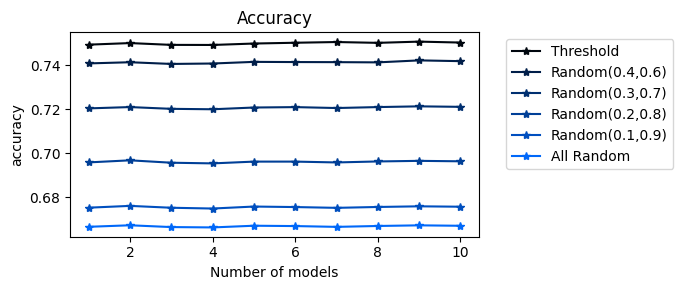

In [7]:
plot(df, "Accuracy", "accuracy")

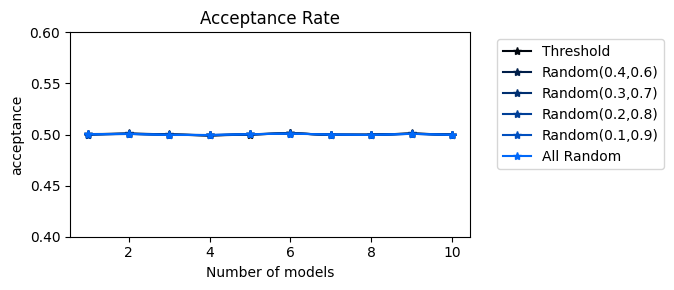

In [8]:
plot(df, "Acceptance Rate", "acceptance", "lockout", False, [0.4, 0.6])

# Results -- Systemic Failure
### Randomization reduces systemic failure (\% of people receiving rejection/inaccurate decisions) 

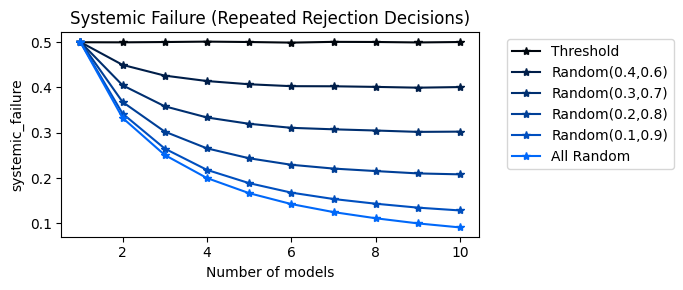

In [9]:
plot(df, "Systemic Failure (Repeated Rejection Decisions)", "systemic_failure", "lockout")

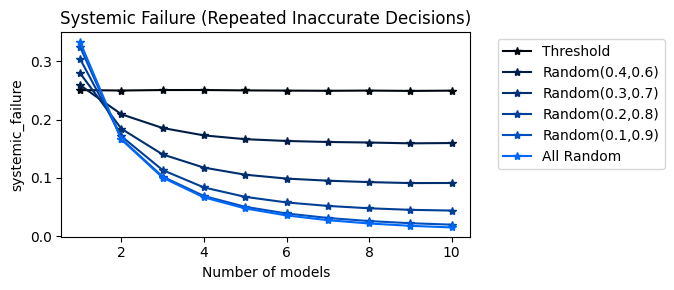

In [10]:
plot(df, "Systemic Failure (Repeated Inaccurate Decisions)", "systemic_failure", "inaccurate")

# Results - Homogenization (Systemic Failure / Expected Failure) 

### Randomization reduces the ratio of systemic failures to expected failures (probability of failure by all models) 

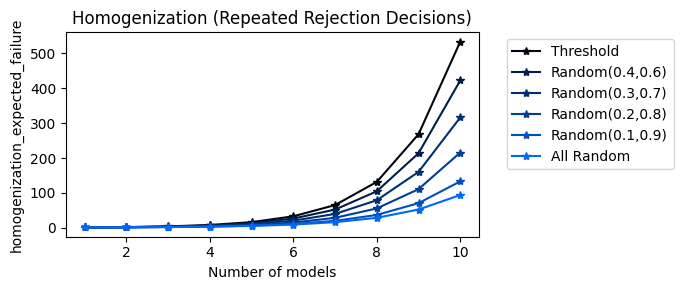

In [11]:
plot(df, "Homogenization (Repeated Rejection Decisions)", "homogenization_expected_failure", "lockout", False)

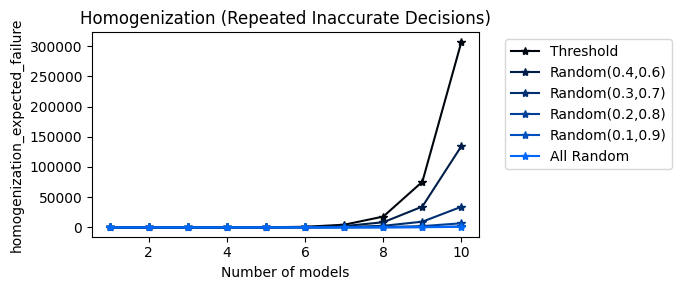

In [12]:
plot(df, "Homogenization (Repeated Inaccurate Decisions)", "homogenization_expected_failure", "inaccurate", False)

# Results - Homogenization (Systemic Failure / Average Failure)

### Randomization reduces the percentage of model failures that are systemic

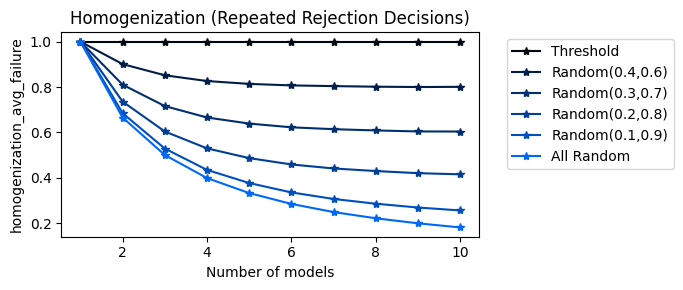

In [13]:
plot(df, "Homogenization (Repeated Rejection Decisions)", "homogenization_avg_failure", "lockout", False)

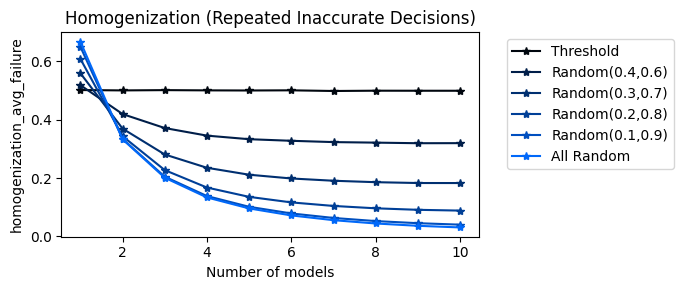

In [14]:
plot(df, "Homogenization (Repeated Inaccurate Decisions)", "homogenization_avg_failure", "inaccurate", False)

# Results - Multiplicity

### Randomization increases the proportion of people that receive multiple outcomes 

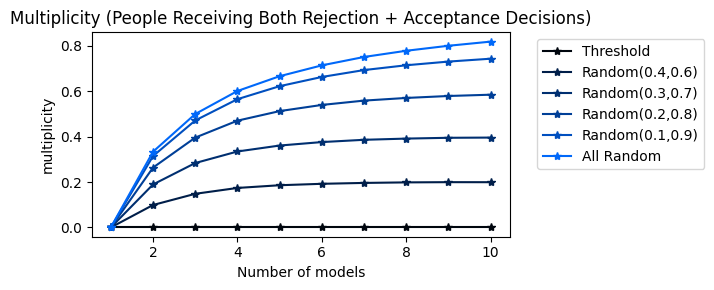

In [15]:
plot(df, "Multiplicity (People Receiving Both Rejection + Acceptance Decisions)", "multiplicity", "lockout", False)

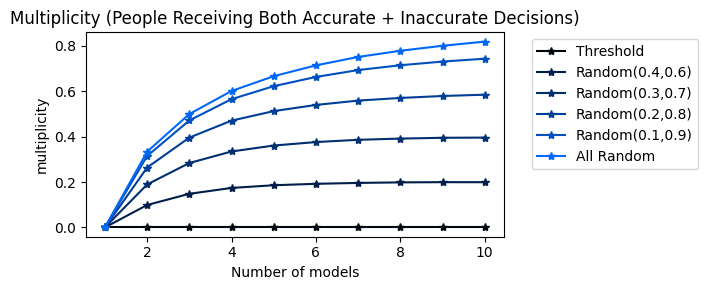

In [16]:
plot(df, "Multiplicity (People Receiving Both Accurate + Inaccurate Decisions)", "multiplicity", "inaccurate", False)